### Задание №1
а)

<Axes: xlabel='count_of_sub_categories', ylabel='Sub-Category'>

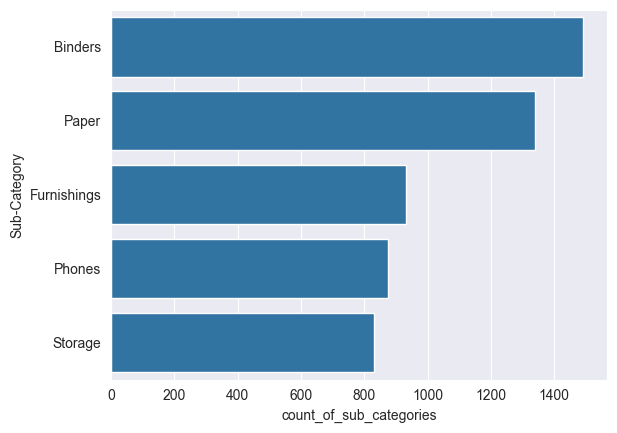

In [136]:
from pyspark.sql import SparkSession, functions as F
import seaborn

spark = SparkSession.builder.getOrCreate()

df = spark.read.format("csv").option("header", "true").load("train.csv")

df_group_1_all_time = df.groupBy("Sub-Category").agg(
    F.count("ID").alias("count_of_sub_categories")
).select("Sub-Category", "count_of_sub_categories").orderBy(-F.col("count_of_sub_categories")).limit(5).toPandas()

seaborn.barplot(x=df_group_1_all_time["count_of_sub_categories"], y=df_group_1_all_time["Sub-Category"])


### Задание № 1
б)

<Axes: >

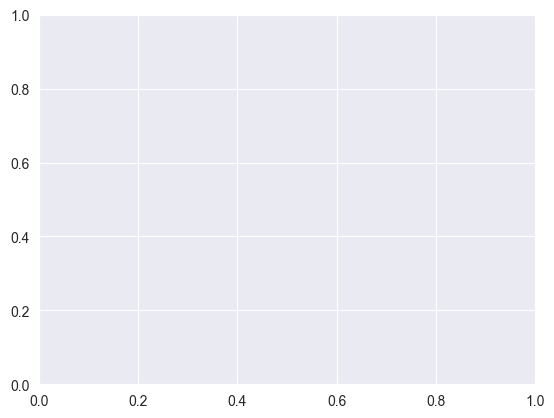

In [137]:
df_1_b = df.withColumn('order_date_formatted', F.to_date("Order Date", "dd/MM/yyyy"))

df_group_1_2years = df_1_b.filter(F.col("Order_date_formatted").between("2022-08-29", "2024-08-29")).groupBy(
    "Sub-Category").agg(
    F.count("ID").alias("count_of_sub_categories")
).select("Sub-Category", "count_of_sub_categories").orderBy(-F.col("count_of_sub_categories")).limit(5).toPandas()

seaborn.barplot(x=df_group_1_2years["count_of_sub_categories"], y=df_group_1_2years["Sub-Category"])





### Задание № 1
в)

<Axes: >

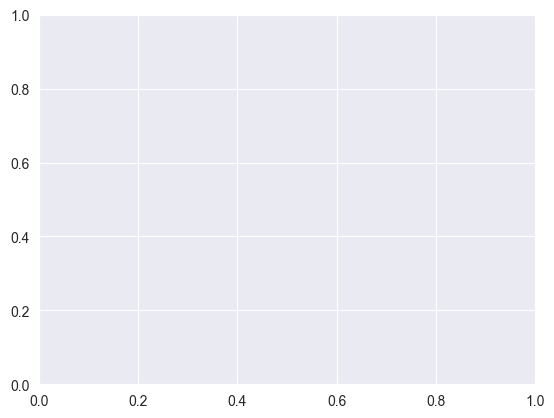

In [135]:
df_group_1_1years = df_1_b.filter(F.col("Order_date_formatted").between("2023-08-29", "2024-08-29")).groupBy(
    "Sub-Category").agg(
    F.count("ID").alias("count_of_sub_categories")
).select("Sub-Category", "count_of_sub_categories").orderBy(-F.col("count_of_sub_categories")).limit(5).toPandas()

seaborn.barplot(x=df_group_1_1years["count_of_sub_categories"], y=df_group_1_1years["Sub-Category"])

### Задание №1 Вывод:
На основе анализа можно сделать вывод о том, что с 2018 года продаж не происходило, а на 2018 год самыми продаваемыми категориями были:
    
    - Binders
    - Paper
    - Furnishings
    - Phones
    - Storage

### Задание №2

<Axes: ylabel='Sales'>

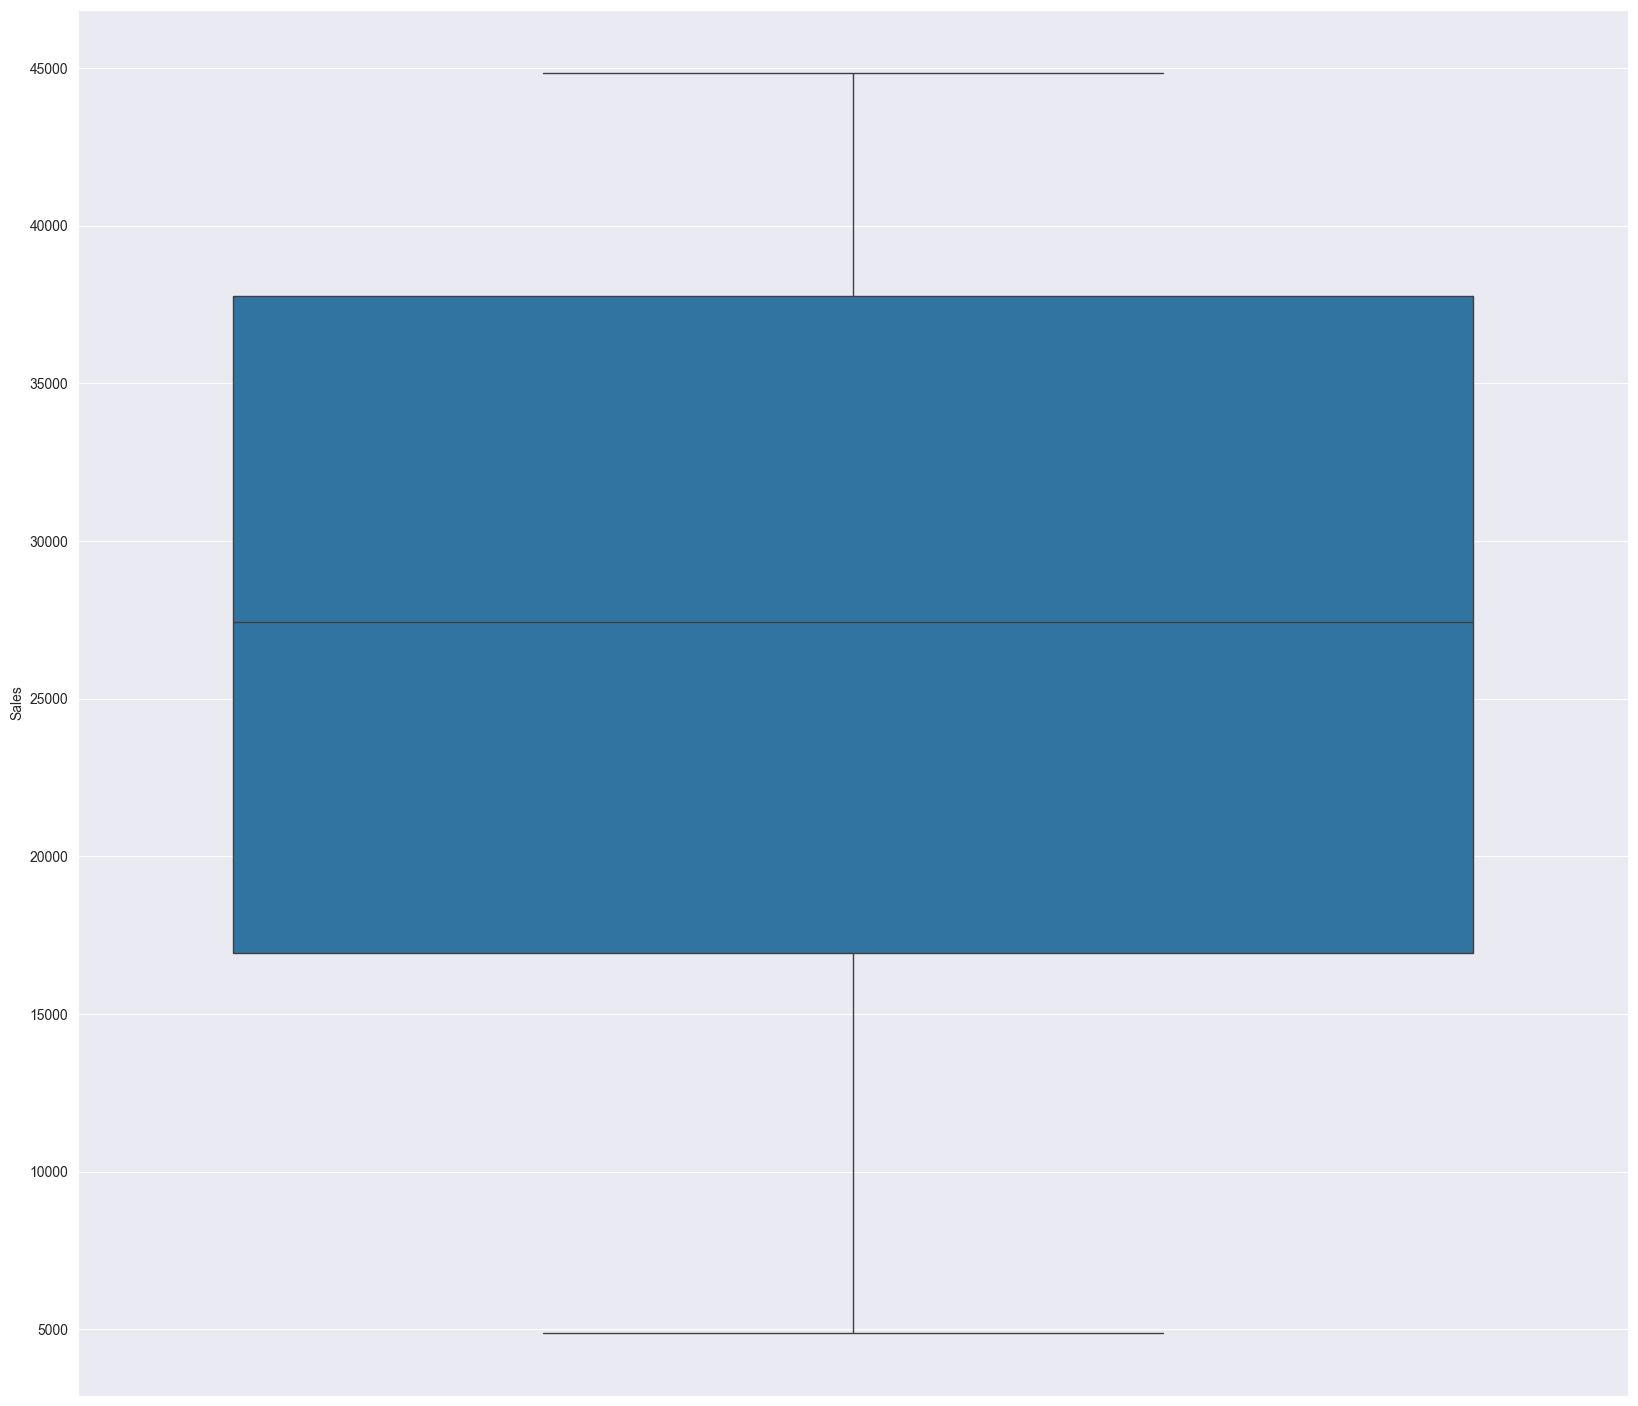

In [138]:
import pandas as pd
from pyspark.sql.types import DoubleType
from matplotlib import pyplot as plt

df_2 = df.withColumn("Sales", F.regexp_replace(F.col("Sales"), "[^0-9.]", "").cast(DoubleType()))

quantiles = df_2.approxQuantile("Sales", [0.25, 0.75], 0.0)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

res_2 = df.filter((F.col("Sales") >= lower_bound) & (F.col("Sales") <= upper_bound)).toPandas()

res_2["Sales"] = pd.to_numeric(res_2["Sales"], errors='coerce')

plt.figure(figsize=(20, 18))

seaborn.boxplot(res_2["Sales"])





### Задание №3
Я поделил покупки на следующие категории:
- Мелкие (до 1000_000)
- Средние (от 1000_000 до 6000_000)
- Крупные (от 6000_000)  

In [134]:


df_3 = df.withColumn("Sales", F.regexp_replace(F.col("Sales"), "[^0-9.]", "").cast(DoubleType()))
# df_3.select(F.max("Sales"), F.min("Sales")).show()

df_3 = df_3.withColumn("Sale_group",
                       F.when(F.col("Sales") < 1000_000, "small").when(
                           F.col("Sales").between(1000_000, 5_999_999), "medium").otherwise(
                           "large")).groupBy(F.col("Region"), F.col("Sale_group")).agg(
    F.sum("Sales").alias("Total Sales")).select("Region", "Sale_group",
                                                F.col("Total Sales")).orderBy(-F.col("Total Sales"),
                                                                              'Sale_group',
                                                                              "Region")

df_3.show()



+-----------+----------+-------------+
|     Region|Sale_group|  Total Sales|
+-----------+----------+-------------+
| Калиниград|    medium|7.261114547E9|
|Владивосток|    medium|6.647401167E9|
|       Урал|    medium|5.267523654E9|
|     Москва|    medium|3.765882932E9|
| Калиниград|     large|1.999263202E9|
|Владивосток|     large|1.679496826E9|
|       Урал|     large|1.400981423E9|
|     Москва|     large|1.021765504E9|
| Калиниград|     small|  9.0331711E7|
|Владивосток|     small|  7.9854266E7|
|       Урал|     small|  5.9150385E7|
|     Москва|     small|  4.8394999E7|
+-----------+----------+-------------+


Задача №3 Вывод:
При моих принципах разделения на группы получились следующие выводы:
   - Наибольшую прибыль приносят средние заказы
   - Рейтинг регионов в порядке убывания общей прибыли вне зависимости от группы продаж:
      1. Калининград
      2. Владивосток
      3. Урал
      4. Москва
   - Региональное разделение на группы значительно влияет на показатели, в отличии от деления по размеру заказа
  
    